In [1]:
!pip install -q transformers datasets torch torchvision albumentations roboflow pytorch_lightning

# Download data set from roboflow

In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="HUBAAfRrsHWybDdGgXbg")
project = rf.workspace("paul-guerrie-tang1").project("balloons-geknh")
dataset = project.version(4).download("png-mask-semantic")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Balloons-4 in png-mask-semantic:: 100%|██████████| 4076/4076 [00:00<00:00, 4359.26it/s]


In [18]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import torch.nn as nn
import pytorch_lightning as pl
import torchvision
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

BASE_PATH = "./Balloons-4"

CHECKPOINT_PATH = "./model_cp/balloon_checkpoint.pth.tar"

# Hyperparameters etc.
LEARNING_RATE = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# print("DEVICE", DEVICE)
BATCH_SIZE = 8
NUM_EPOCHS = 10
NUM_WORKERS = 2
IMAGE_HEIGHT = 512  # 1280 original
IMAGE_WIDTH = 512  # 1918 original
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = f"{BASE_PATH}/train/"
VAL_IMG_DIR = f"{BASE_PATH}/valid/"


# Dataset

In [19]:
class BalloonDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        image_file_names = [f for f in os.listdir(self.root_dir) if '.jpg' in f]
        mask_file_names = [f for f in os.listdir(self.root_dir) if '.png' in f]

        self.images = sorted(image_file_names)
        self.masks = sorted(mask_file_names)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.root_dir, self.images[idx]))
        mask = Image.open(os.path.join(self.root_dir, self.masks[idx]))
        mask = mask.resize(image.size)
        image = np.array(image.convert("RGB"))
        mask =np.array(mask.convert("L"), dtype=np.float32)

        mask[mask == 255] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image,mask=mask)
            image = augmentations['image']
            mask = augmentations['mask']

        return image,mask

In [20]:
train_transform = A.Compose(
    [
        A. Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        # A. Rotate(limit=35, p=1.0),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)
val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)


In [21]:
train_ds = BalloonDataset(
    root_dir=TRAIN_IMG_DIR,
    transform=train_transform,
)

train_loaders = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)

val_ds = BalloonDataset(
    root_dir=VAL_IMG_DIR,
    transform=val_transform,
)
val_loaders = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)


# Unet model

In [22]:
# https://www.youtube.com/watch?v=IHq1t7NxS8k&ab_channel=AladdinPersson
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
import torch.optim as optim
# import torchmetrics
from torchmetrics.classification import Accuracy
LEARNING_RATE = 1e-4
from torchmetrics import Metric

class MyAccuracy(Metric):
    def __init__(self):
        super().__init__()
        self.add_state("total", default=torch.tensor(0, dtype=torch.float), dist_reduce_fx="sum")
        self.add_state("correct", default=torch.tensor(0, dtype=torch.float), dist_reduce_fx="sum")
        self.add_state("dice_score", default=torch.tensor(0, dtype=torch.float), dist_reduce_fx="sum")

    def update(self,preds, targets):
        preds = (preds > 0.5).float()


        self.correct +=  (preds == targets).sum()
        self.total += torch.numel(preds)
        self.dice_score += (2*(preds*targets).sum())/(
            (preds+targets).sum() + 1e-8
        )


    def compute(self):
        # Calculate accuracy and dice coefficient
        accuracy = self.correct.float() / self.total.float()
        dice_score = self.dice_score.float()
        return {'accuracy': accuracy, 'dice_score': dice_score}

class DoubleConv(nn.Module):
    ################################################################
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            # kernel, stride, padding - same convolution
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            # kernel, stride, padding - same convolution
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    ################################################################
    def forward(self, x):
        return self.conv(x)


class UNET(pl.LightningModule):
    ################################################################
    def __init__(self,
                 in_channels=3, out_channels=1,
                 features=[64, 128, 256, 512],
                 metrics_interval=100
                 ):
        super(UNET, self).__init__()
        self._init_unet(in_channels, out_channels, features)

        self.loss_fn = nn.BCEWithLogitsLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=2)
        self.my_accuracy = MyAccuracy()
        self.metrics_interval = metrics_interval
    ################################################################

    def _init_unet(self, in_channels, out_channels, features):
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        return in_channels

        # self.scaler = torch.cuda.amp.grad_scaler.GradScaler()

    ################################################################
    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

    ################################################################
    def training_step(self, batch, batch_idx):
        loss , predictions, targets = self._common_step(batch, batch_idx)
        # self.log('train_loss', loss)
        if True: #batch_idx % self.metrics_interval == 0:
            accuracy = self.my_accuracy(predictions, targets)

            # metrics = self.train_mean_iou.compute(
            #     num_labels=self.num_classes,
            #     ignore_index=255,
            #     reduce_labels=False,
            # )

            metrics = {'loss': loss, "accuracy": accuracy["accuracy"], "dice_score": accuracy["dice_score"]}

            # for k,v in metrics.items():
            #     self.log(k,v)

        else:
            metrics = {'loss': loss}

        self.log_dict(metrics, prog_bar=True)


        return(metrics)

    ################################################################
    def validation_step(self, batch, batch_idx):
        loss , predictions, targets = self._common_step(batch, batch_idx)
        # self.log('val_loss', loss)
        # self.log_dict({'val_loss': loss, 'accuracy': accuracy})
        return loss

    ################################################################
    def test_step(self, batch, batch_idx):
        loss , predictions, targets = self._common_step(batch, batch_idx)
        self.log('test_loss', loss)

        return loss

    ################################################################
    def _common_step(self, batch, batch_idx):
        # Get data and targets
        data, targets = batch
        targets = targets.float().unsqueeze(1)

        # Forward pass with AMP (assuming AMP is enabled)
        # with torch.cuda.amp.autocast():
        predictions = self.forward(data)
        loss = self.loss_fn(predictions, targets)

        # Automatic backward pass and optimizer step (handled by Lightning)

        # Automatic logging (can be configured in trainer)

        return loss , predictions, targets


    ################################################################
    def predict_step(self, batch):
        data, targets = batch
        # with torch.cuda.amp.autocast():
        preds = torch.sigmoid(self.forward(data))

        preds = (preds > 0.5).float()

        return preds


    ################################################################
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=LEARNING_RATE)

################################################################
def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    pred = model(x)
    print(pred.shape)
    print(x.shape)
    assert pred.shape == x.shape


test()

torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


# Train

In [23]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)


In [24]:
trainer = pl.Trainer(
    accelerator="auto",
    devices="auto",
    max_epochs=NUM_EPOCHS,
    # precision=16
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
trainer.fit(model, train_loaders, val_loaders)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params
---------------------------------------------------
0 | downs       | ModuleList         | 4.7 M 
1 | ups         | ModuleList         | 12.2 M
2 | pool        | MaxPool2d          | 0     
3 | bottleneck  | DoubleConv         | 14.2 M
4 | final_conv  | Conv2d             | 65    
5 | loss_fn     | BCEWithLogitsLoss  | 0     
6 | accuracy    | MulticlassAccuracy | 0     
7 | my_accuracy | MyAccuracy         | 0     
---------------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.151   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# del model
# torch.cuda.empty_cache()

 # view results

In [ ]:
loader = val_loaders
folder="./save_images"
device=DEVICE

try:
    os.mkdir(folder)
except FileExistsError:
    print("Directory ",folder," already exists")


In [ ]:
for idx, (x, y) in enumerate(val_loaders):
    x = x.to(device=device)
    with torch.no_grad():
        preds = torch.sigmoid(model(x))
        preds = (preds > 0.5).float()
    torchvision.utils.save_image(preds, os.path.join(folder,f"pred_{idx}.png"))
    torchvision.utils.save_image(y.unsqueeze(1), os.path.join(folder,f"correct_{idx}.png"))

In [27]:

for idx, (pixel_values,masks) in enumerate(val_loaders):
    pixel_values= pixel_values.to(DEVICE)
    print(idx, pixel_values.shape)
    preds = torch.sigmoid(model(pixel_values))
    predicted_mask = (preds > 0.5).float()
    masks = masks.cpu().numpy()
    break # only one batch


0 torch.Size([8, 3, 512, 512])


In [ ]:
print("predicted_mask.shape",predicted_mask.shape)
print("masks.shape",masks.shape)

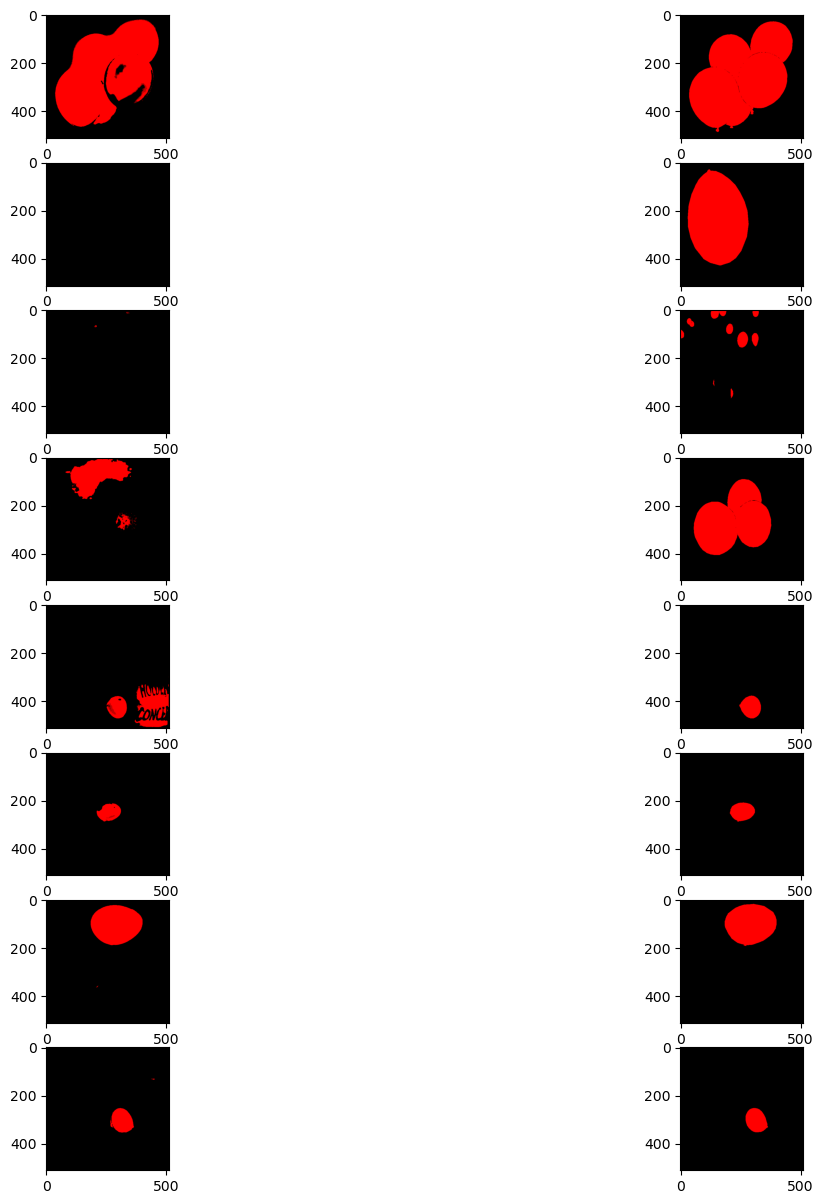

In [29]:
color_map = {
    0:(0,0,0),
    1:(255,0,0),
}

def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i,c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8).squeeze())
n_plots = 8
from matplotlib import pyplot as plt
f, axarr = plt.subplots(n_plots,2)
f.set_figheight(15)
f.set_figwidth(15)
for i in range(n_plots):
    axarr[i,0].imshow(prediction_to_vis(predicted_mask[i,:,:].cpu()))
    axarr[i,1].imshow(prediction_to_vis(masks[i,:,:]))

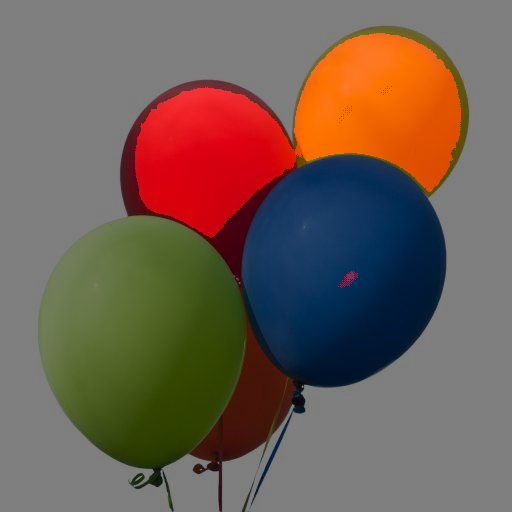

In [32]:
#Predict on a test image and overlay the mask on the original image
test_idx = 0
input_image_file = os.path.join(val_ds.root_dir,val_ds.images[test_idx])
input_image = Image.open(input_image_file)
test_batch = val_ds[test_idx]
images, masks = test_batch
images = torch.unsqueeze(images, 0).to(DEVICE)
masks = torch.unsqueeze(masks, 0)
outputs = model(images)
preds = torch.sigmoid(outputs)
predicted_mask = (preds > 0.5).float()


mask = prediction_to_vis(predicted_mask[test_idx,:,:].cpu())
mask = mask.resize(input_image.size)
mask = mask.convert("RGBA")
input_image = input_image.convert("RGBA")
overlay_img = Image.blend(input_image, mask, 0.5)
overlay_img